In [1]:
from functools import partial

import matplotlib.pyplot as plt

from superfv import EulerSolver
from superfv.initial_conditions import entropy_wave

In [2]:
gamma = 5 / 3
N = 64

In [3]:
sim1d = EulerSolver(
    ic=partial(entropy_wave, gamma=gamma),
    nx=N,
    gamma=gamma,
    p=3,
    ZS=True,
    lazy_primitives="adaptive",
    adaptive_dt=False,
)
sim1d.run(n=1)

dims=('x',), passive_dim='z'
Step #1 @ t=6.25e-03 | dt=6.25e-03 | min(rho)=1.00e+00, min(P)=6.00e-01 | E_cons=0.00e+00 | (ran in 0.03s)


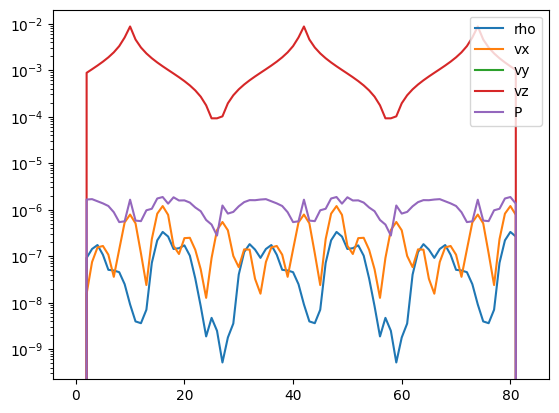

In [4]:
idx = sim1d.variable_index_map
for v in ["rho", "vx", "vy", "vz", "P"]:
    plt.plot(sim1d.arrays["_eta_"][idx(v), :, 0, 0], label=v)
plt.yscale("log")
plt.legend()

In [15]:
sim2d = EulerSolver(
    ic=partial(entropy_wave, gamma=gamma),
    nx=N,
    ny=N,
    gamma=gamma,
    p=3,
    ZS=True,
    lazy_primitives="adaptive",
    adaptive_dt=False,
)
sim2d.run(n=1)

dims=('x', 'y'), passive_dim='z'
Step #1 @ t=3.12e-03 | dt=3.12e-03 | min(rho)=1.00e+00, min(P)=6.00e-01 | E_cons=1.82e-12 | (ran in 0.21s)


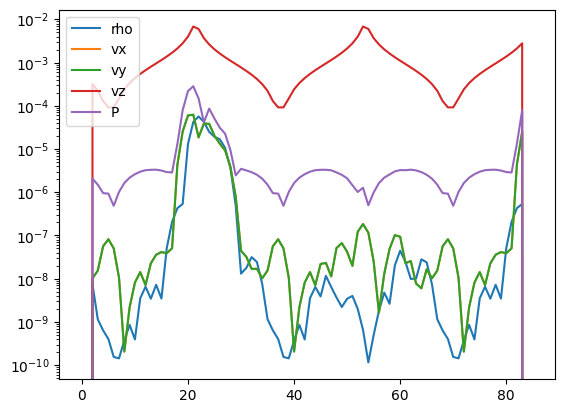

In [16]:
idx = sim2d.variable_index_map
for v in ["rho", "vx", "vy", "vz", "P"]:
    plt.plot(sim2d.arrays["_eta_"][idx(v), :, N // 2, 0], label=v)
plt.yscale("log")
plt.legend()